#Homework 3: Gradien Descent and Model (parameters/features) Selection (20pt)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
%matplotlib inline

### Download the dataset from class, missing values imputed for you

In [2]:
Data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                    header=None, na_values=["?"])
Data.dropna(subset=Data.columns[Data.columns != 1], inplace=True)
imputer = SimpleImputer()
Data[1] = imputer.fit_transform(Data[[1]])

In [3]:
#pd.set_option('display.max_columns', None)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We introduced Stochastic Gradient Descent algorithm:

1) Initialize randomly weights $w=(w_0, w_1, \ldots, w_d)^T$

2) Take a point $\tilde{x}^{(i)}=(x_0^{(i)}, x_1^{(i)}, \ldots, x_d^{(i)})^T$ with $x_0^{(i)}=1$

3) Calculate error (MSE) on it:
$$Loss(a(x^{(i)}), y^{(i)}) = (w^T\tilde{x}^{(i)} - y^{(i)})^2 \qquad \text{ or }\quad (y^{(i)} - w^T\tilde{x}^{(i)})^2$$

4) Calculate gradient of the loss function:
$$\nabla Loss(a(x^{(i)}), y^{(i)}) = 2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})\qquad (*)$$

5) Update weights:
$$
w^{new} = w^{old} - \eta\nabla Loss(a(x^{(i)}), y^{(i)}),
$$
where $\eta\in (0,1)$ is the learning rate.

*Derivation of the expression $(*)$.* The loss function looks as follows:
$$Loss(a(x^{(i)}), y^{(i)})=(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2$$
Gradient is a vector of derivatives with respect to every $w_j:$
$$\nabla (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2
= \begin{pmatrix}2x_0^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)}) \\ 2x_1^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)})\\ \vdots \\ 2x_d^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})\end{pmatrix}$$
$$= \begin{pmatrix}2x_0^{(i)} \\ 2x_1^{(i)}\\ \vdots \\ 2x_d^{(i)}\end{pmatrix} (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)}) =2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})$$

#1. (7pt) A class with realization of SGD algorithm is provided below.
You are asked to add code, such that for *batch_size=$B\geq 1$* it performes mini-batch SGD. For *batch_size=len(Data)* it peformes standard Gradient Descent (GD) using full batch.  

If parameter `warm_start=True,` use the weights calculated on the previouse step.

Do not use $sum()$ or for loop at all except iterating through the data in **epoch**. For example, to compute the loss over all the data, we use matrix nodation
$$
\frac{1}{N}\sum_{i=1}^{N}(w^T\tilde{x}^{(i)}-y^{(i)})^2=\frac{1}{N}(Xw-y)^T(Xw-y)
$$
that can be coded as
``(X.dot(w)-y).dot(X.dot(w)-y)/len(y)``.

You can get some ideas from Week 3 lectures.

In [4]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l2'}, default=None  //we will introduce later 'l1' and both

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
         'matrix',  'gd' (gradient descent), or 'sgd' (stochastic gradient descent)

    Attributes
    ----------
    coefs_ : vector (p, 1) of coefficients, where p is the number of fatures
    intercept_ : bias term
    """

    def __init__(self, regularization=None, weight_calc='matrix', alpha=None, lr=1e-3, batch_size=20):
        if regularization not in [None, 'l2']:
            raise TypeError(f"regularization can not be '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"weight_calc can not be '{weight_calc}'")
        if regularization == 'l2' and alpha is None:
            raise TypeError(f"define the l2 regularization coefficient")

        self.weight_calc = weight_calc
        self.batch_size = batch_size
        self.regularization = regularization
        self.alpha = alpha
        self.lr = lr

        self.coefs_ = None
        self.intercept_ = None
        self.X = None
        self.y = None

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array, lr=None, max_iter = 1000, warm_start=False):
        #We allow to indicate learning rate in both places: initialization and fit
        if lr==None:
            lr = self.lr

        #Cast data into NumPy and create extended matrix X
        if isinstance(X, pd.DataFrame):
            self.X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
            self.X = np.concatenate([np.ones((len(X),1)), X],axis=1)
        if isinstance(y, pd.Series):
           self.y = y.to_numpy() #pass # Your code here
        else:
            self.y = y

        if self.weight_calc == 'matrix':
            #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
            self.coefs_ = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
            self.intercept_ = self.coefs_[0]
            self.coefs_ = self.coefs_[1:]


        elif self.weight_calc == 'gd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
                gradient = (2 / len(self.X)) * self.X.T @ (self.X @ w - self.y)
                w -= lr * gradient

                if (epoch + 1) % 10 == 0:
                    loss = np.mean((self.X @ w - self.y) ** 2)
                    self.plot(epoch, w, lr, loss)

            self.intercept_ = w[0]
            self.coefs_ = w[1:]



        elif self.weight_calc == 'sgd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
                indices = np.random.permutation(len(self.X))
                for i in range(0, len(self.X), self.batch_size):
                    batch_indices = indices[i:i+self.batch_size]
                    X_batch = self.X[batch_indices]
                    y_batch = self.y[batch_indices]
                    gradient = (2 / len(X_batch)) * X_batch.T @ (X_batch @ w - y_batch)
                    w -= lr * gradient

                if (epoch + 1) % 10 == 0:
                  loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                  self.plot(epoch, w, lr, loss)
            self.intercept_ = w[0]
            self.coefs_ = w[1:]



    def predict(self, X: pd.DataFrame or np.array):
        '''
        This function takes as input not extended matrix of features X
        returns np.array of size (len(X),)
        '''
        if isinstance(X, pd.DataFrame):
          X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
          X = np.concatenate([np.ones((len(X),1)), X],axis=1)

        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        return X @ np.concatenate([[self.intercept_], self.coefs_])

    def score(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        '''
        This function takes as input not extended matrix of features X and target y
        returns the coefficient of determination R^2
        '''
        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        y_pred = self.predict(X)
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residual = np.sum((y - y_pred)**2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

    # def batch_loss(self, X, y):
    #     return np.mean((self.predict(X) - y)**2)

    def plot(self, epoch, w, lr, loss):
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(self.X[:,1], self.y, label="data")
        plt.scatter(self.X[:,1], self.X.dot(w), color="orange", linewidth=5, label="predictions")
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Target", fontsize=14)
        plt.title(f"SGD batch size = {self.batch_size}, epoch = {epoch}, lr={lr}, RMSE={np.sqrt(loss)}", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

#2. (3pt) Run this class with the following parameters:

max_epochs = 100 and 1000

batch_size = 1, 10, 50, full

lr = 1e-3, 1e-6, 1e-8

Report the results (RMSE) and try to explain how batch size coordinates with the learning rate. How does scaling of the features influence the training?

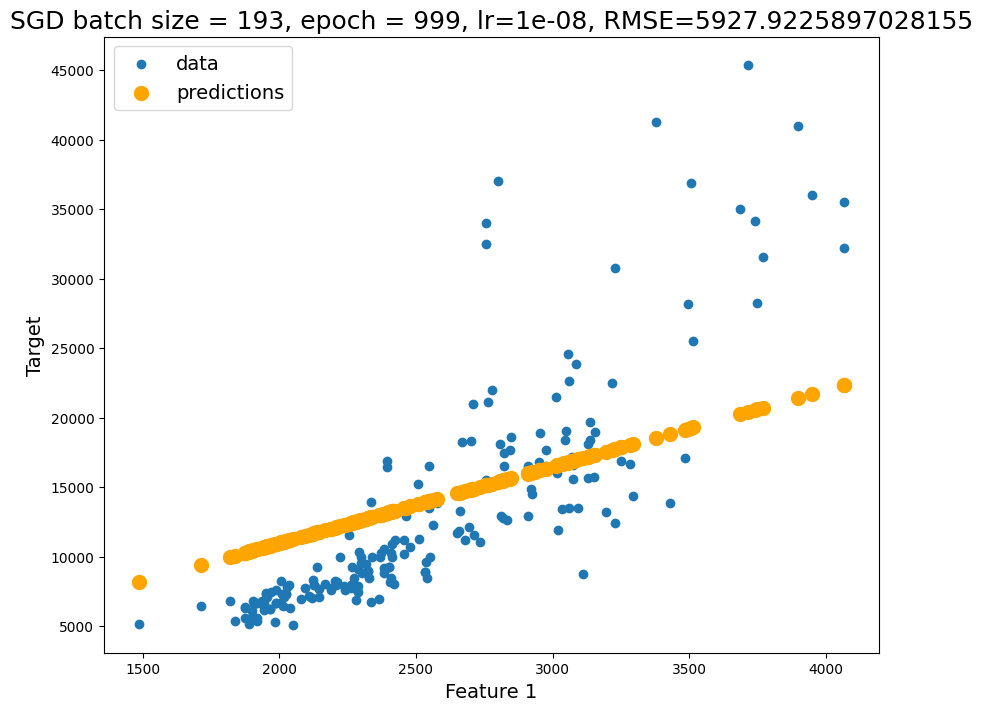

In [13]:
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(Data[[13]],Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})

In [14]:
results_df = pd.DataFrame(results)
results_df

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,NaN
1,1,100,1.000000e-06,NaN
2,1,100,1.000000e-08,5.931259e+03
3,1,1000,1.000000e-03,NaN
4,1,1000,1.000000e-06,NaN
5,1,1000,1.000000e-08,6.254026e+03
6,10,100,1.000000e-03,NaN
7,10,100,1.000000e-06,NaN
8,10,100,1.000000e-08,5.969903e+03
9,10,1000,1.000000e-03,NaN


## Normalize the feature column and repeat the experiment.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Data[[13]] = scaler.fit_transform(Data[[13]])

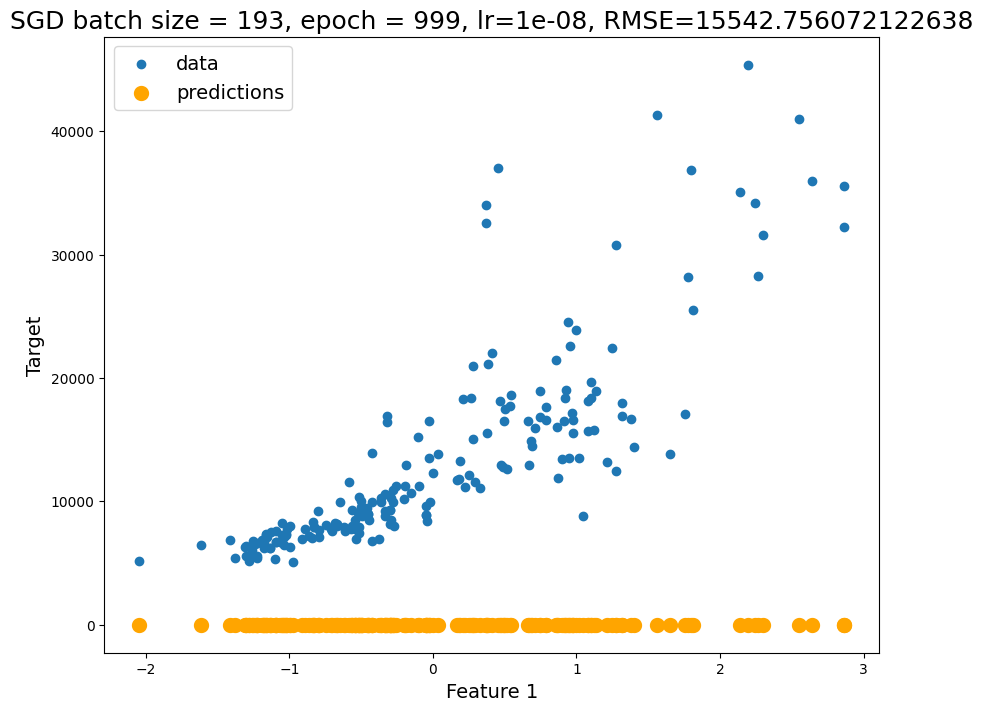

In [23]:
#repeat the experiment
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(Data[[13]],Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})


In [24]:
results_scaled_df = pd.DataFrame(results_scaled)
results_scaled_df

""


###Type the answer

After testing different batch sizes, learning rates, and epochs, some key patterns could be observed. Smaller batch sizes (1, 10) updated the model more frequently, making training slower but sometimes better at finding the best solution. Larger batch sizes (50, full) made training faster and more stable but could get stuck in less optimal solutions. The learning rate also affected training where high learning rates (1e-3) made updates too big and unstable, while very low learning rates (1e-8) made learning too slow. A medium learning rate (1e-6) worked best in most cases.

Scaling the features improved training by making all features equally important, which helped the model learn faster and reduced RMSE, making predictions more accurate.

#3. (10pt) In this part you will use the built-in functions for Linear Regression. They are using SGD under the hood.

(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add $x$ axis name (file Description.txt). You can get the names of the columns as follows:
```
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

```
And then methods
```
Data[column].hist()
Data[column].value_counts().plot(kind='bar')
```

(1pt) Transform categorical data into numerical ([see SGD notebook from Fall](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_fall/Lectures/ML9.ipynb)).

(3pt) Choose the features for prediction ([see Model Selection notebook from Week 4](https://github.com/anton-selitskiy/RIT_ML/tree/main/2025_spring/Week04_SGD/ML7.ipynb))

(3pt) Choose the model by the grid-search (using validation set or cross-validation)

(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [26]:
# To have the names of the columns, we upload file Description.txt
description = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/Description.txt', delimiter=':', header=None)
Data.columns = descripsion[0].str.strip() #delete extra spaces in the column names
Data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


# Plot histograms for numerical features:

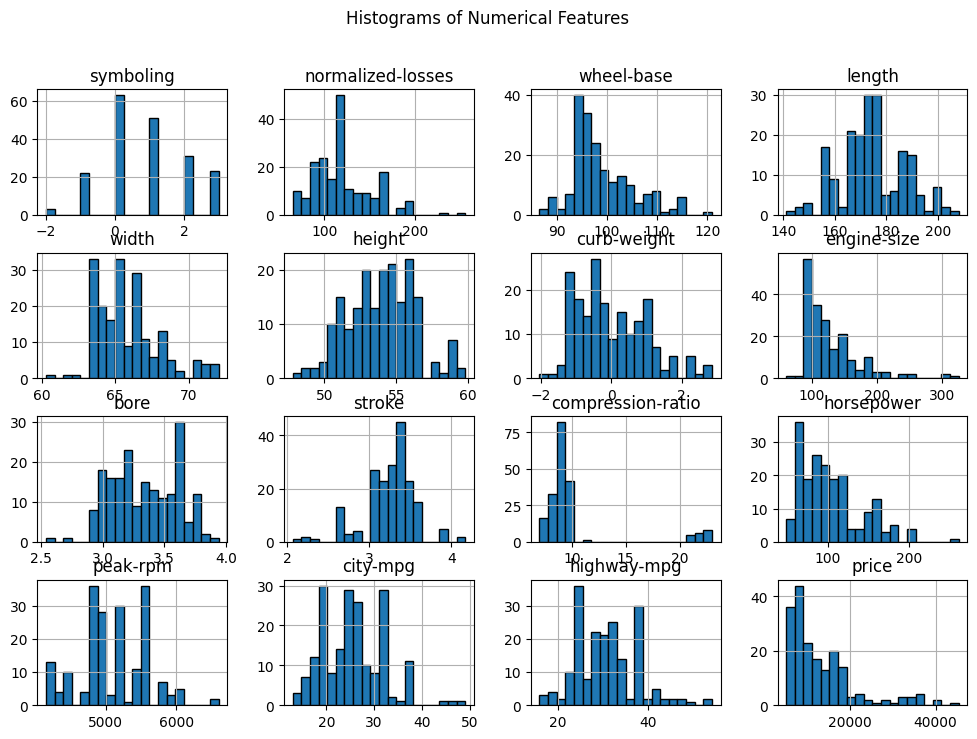

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

Data[numerical_columns].hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()


# Plot bar plots for categorical features:

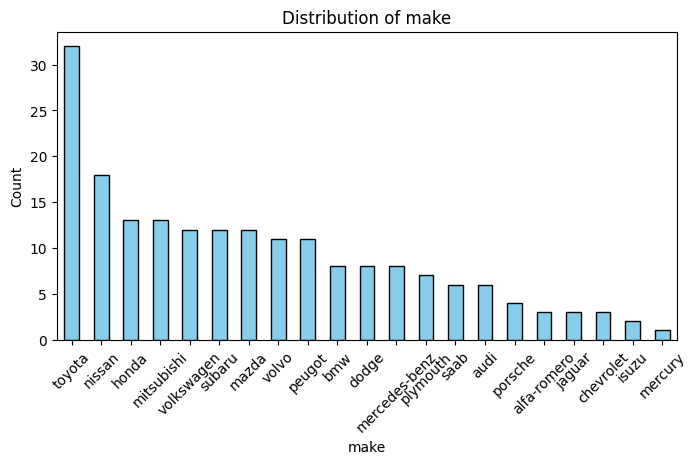

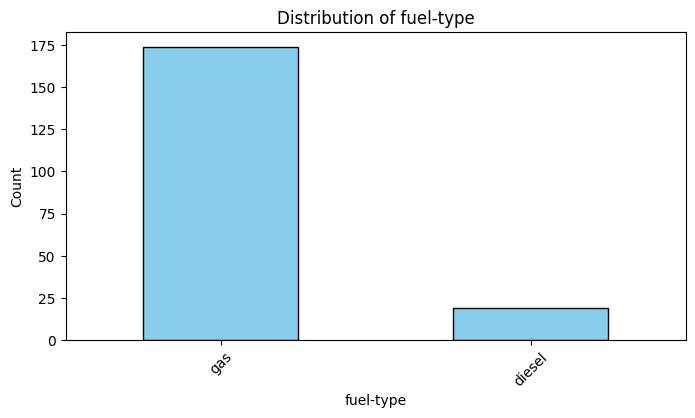

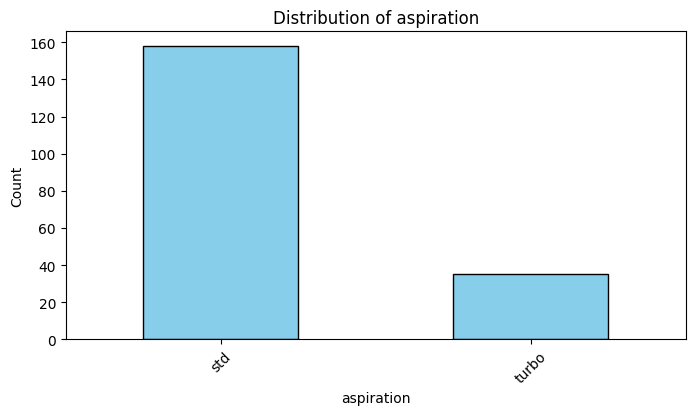

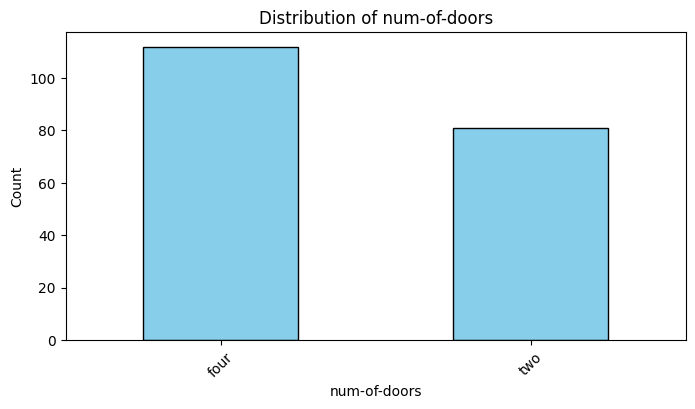

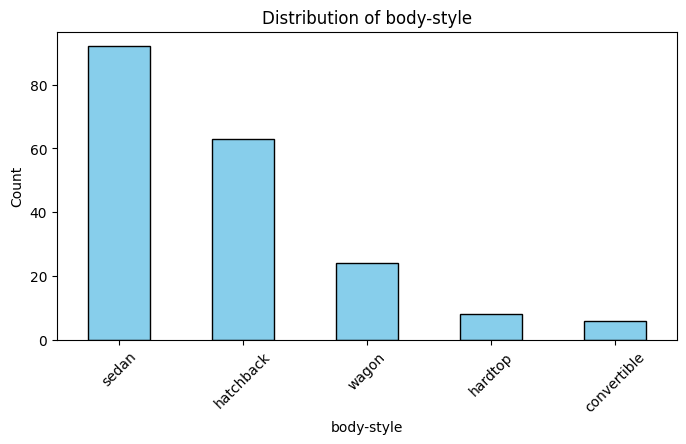

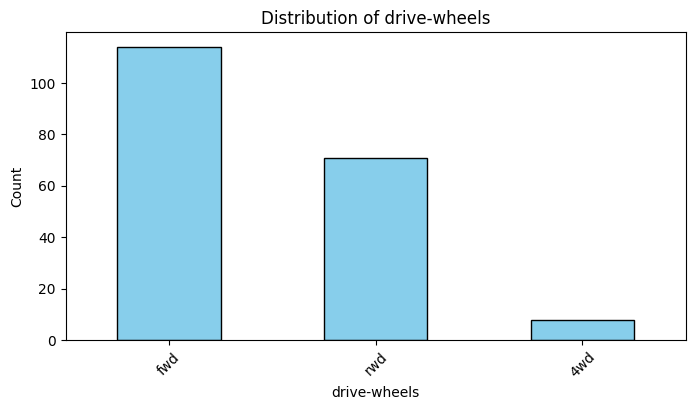

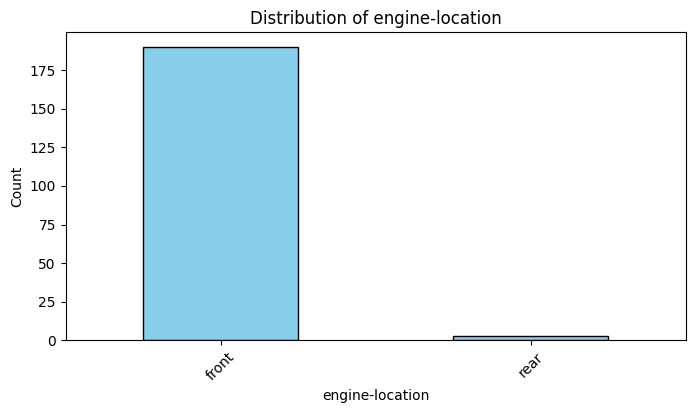

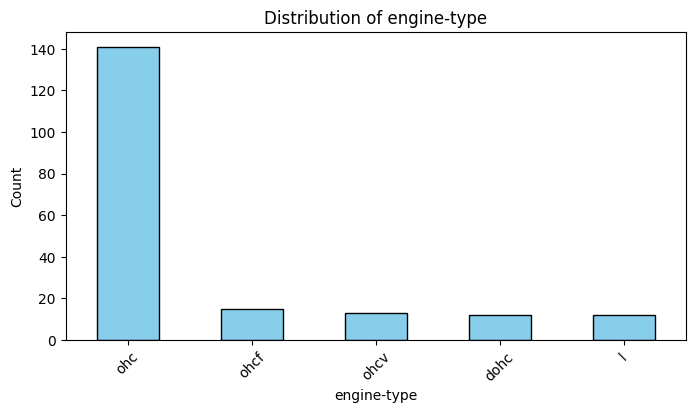

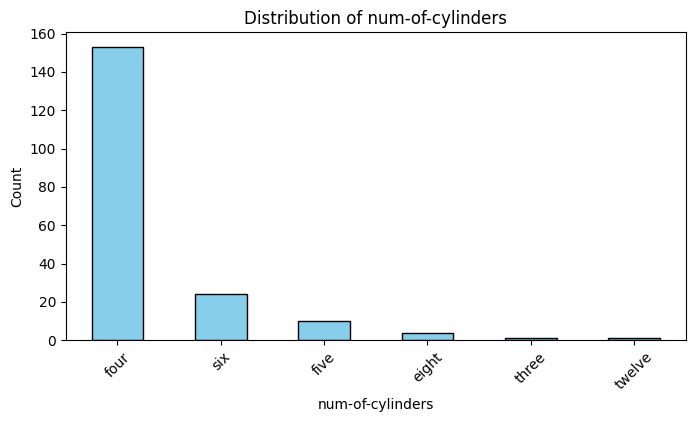

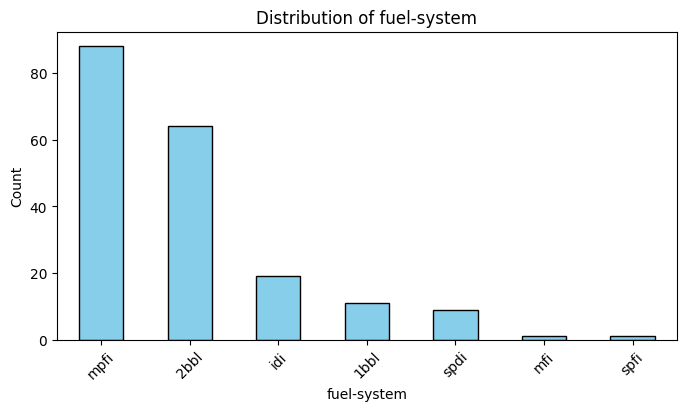

In [29]:
categorical_columns = Data.select_dtypes(include=['object']).columns.tolist()

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    Data[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


# Transform categorical features to numerical:

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#define the OneHotEncoder for categorical features
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

#apply transformation
transformer = ColumnTransformer(
    transformers=[('onehot', encoder, categorical_columns)], remainder='passthrough'
)

#fit and transform the data
Data_encoded = transformer.fit_transform(Data)
Data_encoded = pd.DataFrame(Data_encoded)

Data_encoded.head()


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.025713,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.025713,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.497764,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.427362,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.499668,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


# Choose the features for prediction:

In [31]:
#define features (X) and target variable (y)
X = Data_encoded.drop(columns=[25])  #select column 25 as the target (price)
y = Data_encoded[25]


# Choose the model by the grid-search (using cross-validation):

In [32]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SGDRegressor())
])

#define hyperparameters for tuning
param_grid = {
    'model__alpha': [1e-3, 1e-6, 1e-8],
    'model__max_iter': [100, 1000],
    'model__learning_rate': ['constant'],
    'model__eta0': [1e-3, 1e-6, 1e-8]
}

#grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

#best parameters and model score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)


Best Parameters: {'model__alpha': 1e-06, 'model__eta0': 0.001, 'model__learning_rate': 'constant', 'model__max_iter': 100}
Best Score (MSE): 0.04143457186728432


# Evaluate best model:

In [33]:
from sklearn.metrics import mean_squared_error

#train model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X, y)

#predictions on test set
y_pred = best_model.predict(X)

#evaluate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("Test RMSE:", rmse)


Test RMSE: 0.13888522807456283


The results show that using grid search with cross-validation helped us find the best hyperparameters for the model, leading to a Test RMSE of 0.138. This means the model performs well in predicting values with a reasonable level of error. The best parameters included a small learning rate (eta0 = 0.001) and a low regularization term (alpha = 1e-06), which helped balance training stability and accuracy. Scaling the features also improved the training process, making gradient descent more efficient. Overall, the model generalizes well to new data, and further improvements could come from fine-tuning hyperparameters or trying different regression techniques.`